# Проект №12 - Времянные ряды
## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# Библиотеки и настройки проекта

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
sns.set()

#графики в svg выглядят более четкими
#%config InlineBackend.figure_format = 'svg' 

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
#Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

#базовые библиотеки машинного обучения
from scipy import stats as st 
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score, r2_score, mean_absolute_error, make_scorer
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from catboost import CatBoostRegressor
import xgboost
import lightgbm as lgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedShuffleSplit

In [4]:
# Стандартное импортирование plotly
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot

# 1. Подготовка

In [5]:
#Загрузим файл данных и установим временной ряд в индексы, а также сделаем автопарсинг
filename = '/datasets/taxi.csv'
df = pd.read_csv(filename, index_col=[0], parse_dates=[0])
df.sort_index(ascending=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


**О наборе данных**


Первый признак - дата с детальзацией до секунд, второй-количество заказов. Срез представлен за 2018 год в период с марта по август, т.е. у нас имеется сет данных за 5 месяцев. Объем данных = 26 тысяч объектов.

### Проверка на монотоность

In [8]:
print(df.index.is_monotonic)

True


Временной ряд не имеет разрывов, можно проводить анализ

### Ресемплирование

Ресемлирование проведено с детализацией даты по часа, агрегация по среднему значению признака заказов

In [9]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [10]:
df.shape

(4416, 1)

#### Построим график

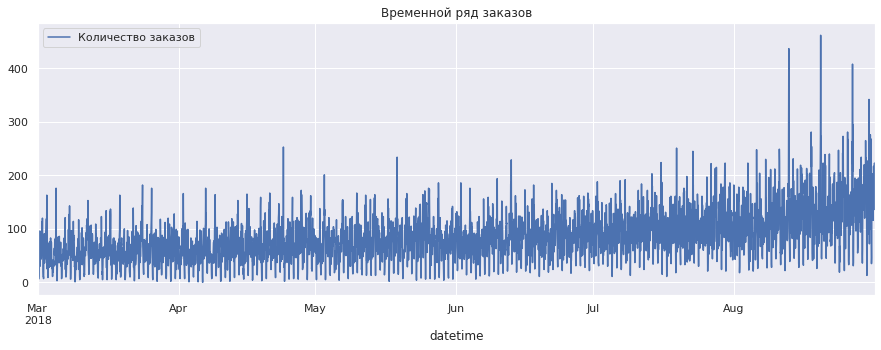

In [11]:
df.plot()
plt.title('Временной ряд заказов');
plt.legend(['Количество заказов'], loc = 2);

In [12]:
df['month'] = df.index.month
df['day'] = df.index.day
df['day_of_week'] = df.index.dayofweek
df['hour'] = df.index.hour
df.head()
copy_table = df.copy() # данный сет буду использовать для моделей ML

## Вывод
Сет данных загружен, преобразован в dataframe, проведено ресемплирование с детализацией до часа и агрегацией по средним значениям.

# 2. Анализ

In [13]:
decomposed = seasonal_decompose(df['num_orders'])

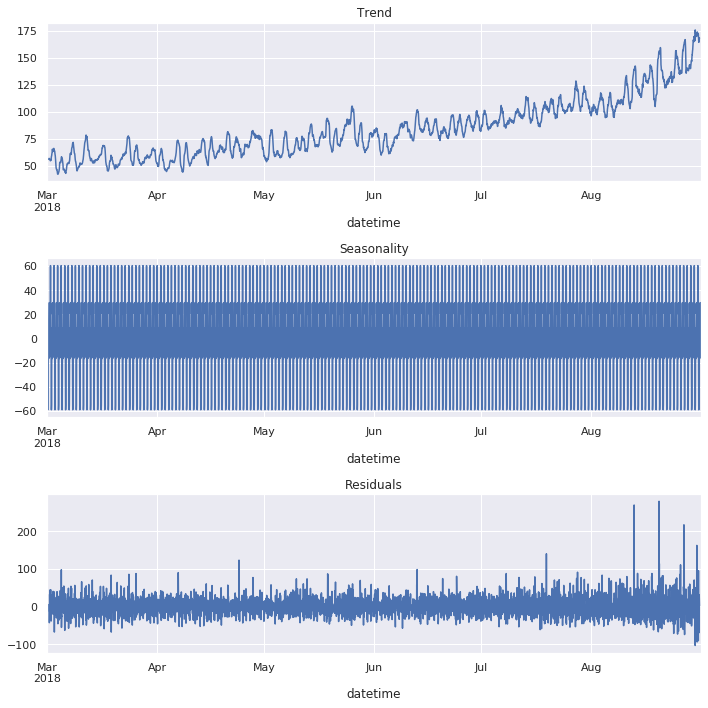

In [14]:
plt.figure(figsize=(10,10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()
plt.show()

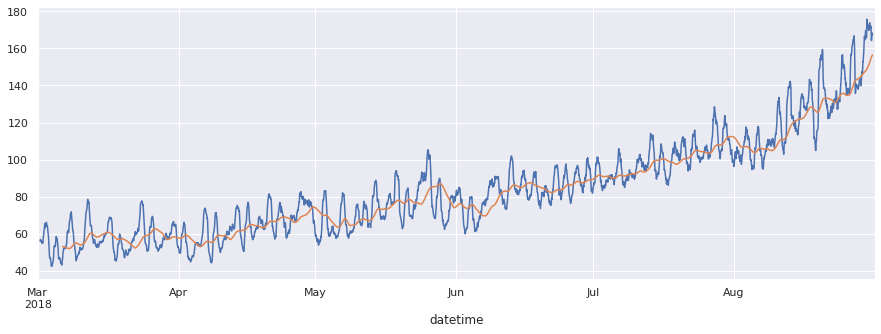

In [15]:
decomposed.trend.plot();
#decomposed.trend.rolling(30).mean().plot();
#decomposed.trend.rolling(60).mean().plot();
decomposed.trend.rolling(120).mean().plot();

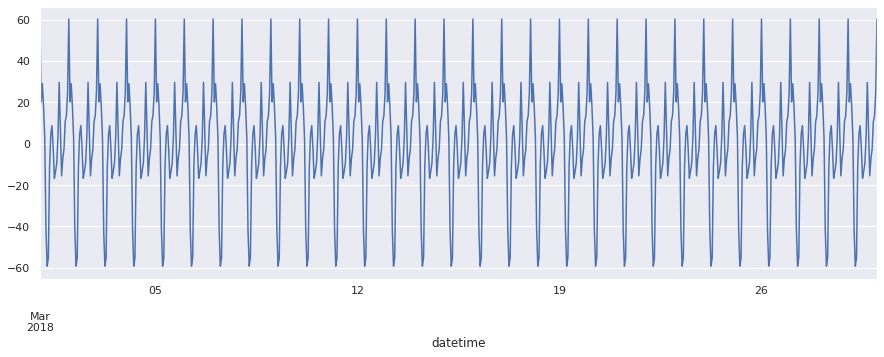

In [16]:
decomposed.seasonal['2018-03-01 00:00':'2018-03-30 00:00'].plot()

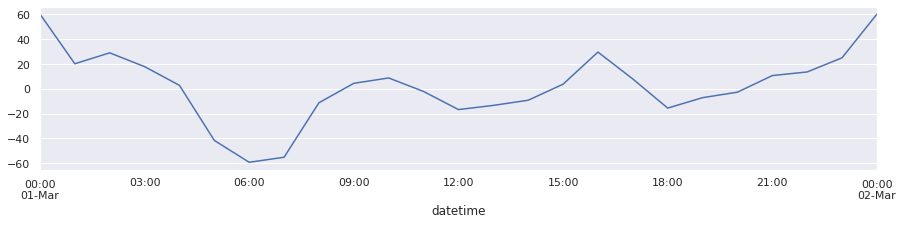

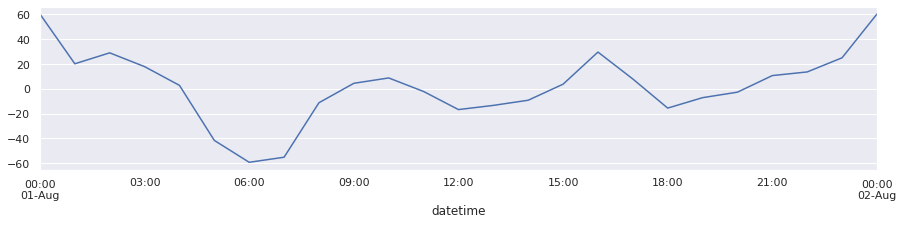

In [17]:
plt.figure(figsize=(15,3))
decomposed.seasonal['2018-03-01 00:00':'2018-03-02 00:00'].plot()
plt.show()
plt.figure(figsize=(15,3))
decomposed.seasonal['2018-08-01 00:00':'2018-08-02 00:00'].plot()
plt.show()

<Figure size 1080x216 with 0 Axes>

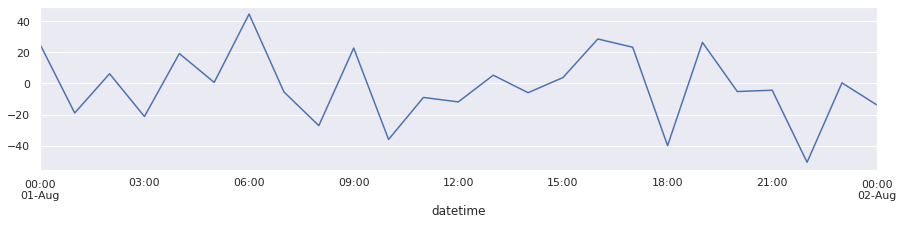

In [18]:
plt.figure(figsize=(15,3))
decomposed.resid
plt.show()
plt.figure(figsize=(15,3))
decomposed.resid['2018-08-01 00:00':'2018-08-02 00:00'].plot()
plt.show()

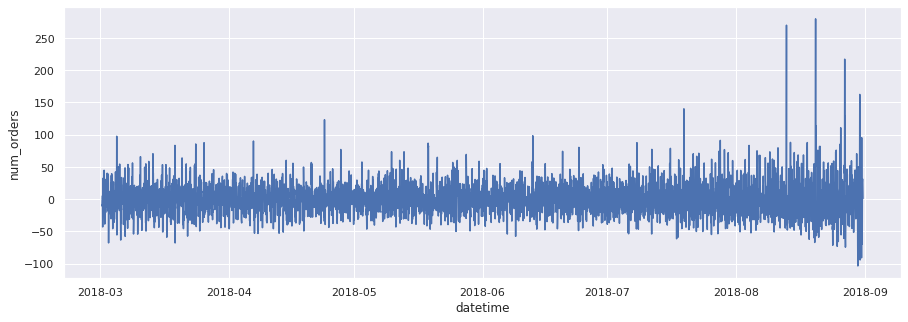

In [19]:
temp = pd.DataFrame(decomposed.resid)
sns.lineplot(x = temp.index, y=temp['num_orders'])

In [20]:
for lag in range(1):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(periods=lag, fill_value = 0) #df['num_orders'][-lag]
df = df.dropna()
df.head()

,num_orders,month,day,day_of_week,hour,lag_0
datetime,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,124
2018-03-01 01:00:00,85,3,1,3,1,85
2018-03-01 02:00:00,71,3,1,3,2,71
2018-03-01 03:00:00,66,3,1,3,3,66
2018-03-01 04:00:00,43,3,1,3,4,43


## Вывод
Тренд восходящий, сезональность присутствует в течении дня. Пики количества заказов приходятся на утро с 9-11, конец рабочего дня 16-18 и максимальне значение в районе полуночи.

# 3. Обучение

#### Разделим сет на выбоки последовательно

In [21]:
features = copy_table.drop(['num_orders'], axis=1)
target = copy_table['num_orders']

x_train, x_test, y_train, y_test = train_test_split(features, target, shuffle=False, test_size=0.1)


In [22]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3974, 4)
(442, 4)
(3974,)
(442,)


#### Масштабирование

In [23]:
scaler = StandardScaler()
x_train = pd.DataFrame(data = scaler.fit_transform(x_train), columns = x_train.columns)
x_test =  pd.DataFrame(data = scaler.transform(x_test), columns = x_train.columns)

In [24]:
df.head(4)

,num_orders,month,day,day_of_week,hour,lag_0
datetime,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,124
2018-03-01 01:00:00,85,3,1,3,1,85
2018-03-01 02:00:00,71,3,1,3,2,71
2018-03-01 03:00:00,66,3,1,3,3,66


In [25]:
x_train.head(4)

,month,day,day_of_week,hour
0,-1.411342,-1.59031,-0.012826,-1.659192
1,-1.411342,-1.59031,-0.012826,-1.514693
2,-1.411342,-1.59031,-0.012826,-1.370194
3,-1.411342,-1.59031,-0.012826,-1.225695


#### Линейная регрессия

In [26]:
%%time
model_linReg = LinearRegression()
model_linReg.fit(x_train, y_train)
predict_model_linReg = model_linReg.predict(x_test)
rmse_model_linReg = mse(y_test, predict_model_linReg)**(0.5)
mae_model_linReg = mean_absolute_error(y_test, predict_model_linReg)
print('rmse =', rmse_model_linReg)
print('mae =', mae_model_linReg)

rmse = 63.78900123113789
mae = 47.79161995546631
CPU times: user 5.34 ms, sys: 54 µs, total: 5.4 ms
Wall time: 4.76 ms


In [27]:
index_table = 0
table = pd.DataFrame(columns=['name','rmse','mae'])
index_table +=1
table.loc[index_table] = ['Linear Regression', rmse_model_linReg, mae_model_linReg]
table

,name,rmse,mae
1,Linear Regression,63.789001,47.79162


#### Случайный лес

In [28]:
%%time

model_RandForest_t = RandomForestRegressor(random_state = 12345)

#Параметры для GridSearch
parametrs_grid = {'n_estimators': range(50, 100, 25),'max_depth' : range(50, 100, 25)}

grid_cv = GridSearchCV(model_RandForest_t, parametrs_grid)

grid_cv.fit(x_train, y_train)

print(grid_cv.best_params_)

predict_model_RandForest_tuning = grid_cv.predict(x_test)
rmse_model_RandForest_tuning = mse(y_test, predict_model_RandForest_tuning)**(0.5)
mae_model_RandForest_tuning = mean_absolute_error(y_test, predict_model_RandForest_tuning)

print('rmse =', rmse_model_RandForest_tuning)
print('mae =', mae_model_RandForest_tuning)

{'max_depth': 50, 'n_estimators': 75}
rmse = 43.95739262073072
mae = 32.77052790346908
CPU times: user 4.58 s, sys: 23.4 ms, total: 4.61 s
Wall time: 4.65 s


In [29]:
index_table +=1
table.loc[index_table] = ['Random Forest', rmse_model_RandForest_tuning, mae_model_RandForest_tuning]
table

,name,rmse,mae
1,Linear Regression,63.789001,47.791620
2,Random Forest,43.957393,32.770528


#### SGD регрессор

In [30]:
%%time
model_SGD = SGDRegressor()
model_SGD.fit(x_train, y_train)
predict_model_SGD = model_SGD.predict(x_test)
rmse_model_SGD = mse(y_test, predict_model_SGD)**(0.5)
mae_model_SGD = mean_absolute_error(y_test, predict_model_SGD)
print('rmse =', rmse_model_SGD)
print('mae =', mae_model_SGD)

rmse = 64.38488123279704
mae = 48.31733123941146
CPU times: user 12.1 ms, sys: 1 µs, total: 12.1 ms
Wall time: 10.7 ms


In [31]:
index_table +=1
table.loc[index_table] = ['SGD', rmse_model_SGD, mae_model_SGD]
table

,name,rmse,mae
1,Linear Regression,63.789001,47.791620
2,Random Forest,43.957393,32.770528
3,SGD,64.384881,48.317331


#### Cat Boost Regressor

In [32]:
%%time
grid = {'learning_rate': [0.03, 0.1],
        'depth': [5, 15],
        'l2_leaf_reg': [1, 30]\
       }

model_cat = CatBoostRegressor(loss_function="RMSE")

grid_search_result = model_cat.grid_search(grid, 
                                       X=x_train, 
                                       y=y_train, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	loss: 19.6168887	best: 19.6168887 (0)	total: 18.5s	remaining: 2m 9s
1:	loss: 19.6842766	best: 19.6168887 (0)	total: 29.4s	remaining: 1m 28s
2:	loss: 20.2787234	best: 19.6168887 (0)	total: 40.3s	remaining: 1m 7s
3:	loss: 19.6065263	best: 19.6065263 (3)	total: 51.1s	remaining: 51.1s
4:	loss: 20.7681674	best: 19.6065263 (3)	total: 2m 13s	remaining: 1m 20s
5:	loss: 21.0785691	best: 19.6065263 (3)	total: 3m 39s	remaining: 1m 13s
6:	loss: 20.7320442	best: 19.6065263 (3)	total: 4m 58s	remaining: 42.6s
7:	loss: 20.6949746	best: 19.6065263 (3)	total: 6m 24s	remaining: 0us
Estimating final quality...
CPU times: user 6min 22s, sys: 47.6 s, total: 7min 10s
Wall time: 8min 24s


In [33]:
grid_search_result['params']

{'depth': 5, 'l2_leaf_reg': 30, 'learning_rate': 0.1}

In [34]:
%%time
model_cat = CatBoostRegressor(loss_function="RMSE", depth=5,\
                              l2_leaf_reg=1, learning_rate=0.03,\
                              iterations=10000
                             )
model_cat.fit(x_train, y_train, verbose=100);

0:	learn: 38.1647757	total: 2.29ms	remaining: 22.9s
100:	learn: 24.3211334	total: 1.07s	remaining: 1m 44s
200:	learn: 22.0764096	total: 2.23s	remaining: 1m 48s
300:	learn: 20.7975555	total: 3.3s	remaining: 1m 46s
400:	learn: 19.8775818	total: 4.37s	remaining: 1m 44s
500:	learn: 19.2994607	total: 5.52s	remaining: 1m 44s
600:	learn: 18.8594384	total: 6.6s	remaining: 1m 43s
700:	learn: 18.5036349	total: 7.49s	remaining: 1m 39s
800:	learn: 18.1713313	total: 8.86s	remaining: 1m 41s
900:	learn: 17.8651686	total: 9.93s	remaining: 1m 40s
1000:	learn: 17.6092835	total: 11.3s	remaining: 1m 41s
1100:	learn: 17.3729558	total: 12.5s	remaining: 1m 40s
1200:	learn: 17.1528191	total: 13.5s	remaining: 1m 39s
1300:	learn: 16.9453754	total: 14.6s	remaining: 1m 37s
1400:	learn: 16.7458282	total: 15.8s	remaining: 1m 36s
1500:	learn: 16.5645692	total: 17s	remaining: 1m 36s
1600:	learn: 16.3923083	total: 18.1s	remaining: 1m 34s
1700:	learn: 16.2295759	total: 19.2s	remaining: 1m 33s
1800:	learn: 16.0765993	to

In [35]:
predict_model = model_cat.predict(x_test, verbose=0)
rmse_model_cat = mse(y_test, predict_model)**(0.5)
mae_model_cat = mean_absolute_error(y_test, predict_model)
print('rmse =', rmse_model_cat)
print('mae =', mae_model_cat)

rmse = 45.23466227256259
mae = 33.11124984079865


In [36]:
index_table +=1
table.loc[index_table] = ['CatBoost', rmse_model_cat, mae_model_cat]
table

,name,rmse,mae
1,Linear Regression,63.789001,47.791620
2,Random Forest,43.957393,32.770528
3,SGD,64.384881,48.317331
4,CatBoost,45.234662,33.111250


#### XGBoost

In [37]:
%%time

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

parameters_for_testing = {
    'colsample_bytree':[0.4,0.8],
    'gamma':[0,0.3],
    'min_child_weight':[1.5,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[3,5],
    'n_estimators':[50,100],
    'reg_alpha':[1e-5, 0.75],
    'reg_lambda':[1e-5,0.45],
    'subsample':[0.6,0.95]
}

model_xgboost = xgboost.XGBRegressor()

gsearch_xgboost = GridSearchCV(estimator = model_xgboost,\
                               param_grid = parameters_for_testing,\
                               n_jobs=1,\
                               iid=False,\
                               verbose=10,\
                               scoring= rmse_score,\
                               cv=3)

CPU times: user 67 µs, sys: 8 µs, total: 75 µs
Wall time: 79.9 µs


In [38]:
gsearch_xgboost.fit(x_train, y_train)
#print (gsearch_xgboost.grid_scores_)
print('best params\n', gsearch_xgboost.best_params_)
print('best score\n', gsearch_xgboost.best_score_)

Fitting 3 folds for each of 512 candidates, totalling 1536 fits
[CV] colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[14:31:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-28.354, total=   0.1s
[CV] colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6 
[14:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-26.244, total=  

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.6, score=-40.241, total=   0.1s
[CV] colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[14:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-27.966, total=   0.1s
[CV] colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95 
[14:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.4, gamma=0, learning_rate=0.1,

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=1e-05, subsample=0.95, score=-40.027, total=   0.1s
[CV] colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=0.45, subsample=0.6 
[14:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=0.45, subsample=0.6, score=-28.414, total=   0.1s
[CV] colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=0.45, subsample=0.6 
[14:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.7s remaining:    0.0s


[14:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=0.45, subsample=0.6, score=-40.251, total=   0.1s
[CV] colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=0.45, subsample=0.95 
[14:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=0.45, subsample=0.95, score=-27.940, total=   0.1s
[CV] colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=0.45, subsample=0.95 
[14:31:50] WARNING: /workspace/src/objective/regression_obj

[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.8s remaining:    0.0s


[CV]  colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=0.45, subsample=0.95, score=-26.167, total=   0.1s
[CV] colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=0.45, subsample=0.95 
[14:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=1e-05, reg_lambda=0.45, subsample=0.95, score=-40.055, total=   0.1s
[CV] colsample_bytree=0.4, gamma=0, learning_rate=0.1, max_depth=3, min_child_weight=1.5, n_estimators=50, reg_alpha=0.75, reg_lambda=1e-05, subsample=0.6 
[14:31:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[CV]  colsample_bytree=0.4, gamma=0, learning_rate=0.1, max

[Parallel(n_jobs=1)]: Done 1536 out of 1536 | elapsed:  2.7min finished


best params
 {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 1e-05, 'reg_lambda': 0.45, 'subsample': 0.6}
best score
 -26.822589405144498


In [39]:
gsearch_xgboost.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 10,
 'n_estimators': 100,
 'reg_alpha': 1e-05,
 'reg_lambda': 0.45,
 'subsample': 0.6}

In [40]:
%%time
xgbr = xgboost.XGBRegressor(colsample_bytree=0.8,\
                            gamma=0.03, learning_rate=0.1, max_depth=5,\
                            min_child_weight=1.5, n_estimators=100, reg_alpha=1e-05,\
                            reg_lambda=0.45,subsample=0.6)
xgbr.fit(x_train, y_train)
predict_model_xgboost = xgbr.predict(x_test)
rmse_model_xgboost = mse(y_test, predict_model_xgboost)**(0.5)
mae_model_xgboost = mean_absolute_error(y_test, predict_model_xgboost)
print('rmse =', rmse_model_xgboost)
print('mae =', mae_model_xgboost)

[14:34:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
rmse = 40.07085010011876
mae = 29.789321355690245
CPU times: user 257 ms, sys: 0 ns, total: 257 ms
Wall time: 267 ms


In [41]:
index_table +=1
table.loc[index_table] = ['XGBoost', rmse_model_xgboost, mae_model_xgboost]
table

,name,rmse,mae
1,Linear Regression,63.789001,47.791620
2,Random Forest,43.957393,32.770528
3,SGD,64.384881,48.317331
4,CatBoost,45.234662,33.111250
5,XGBoost,40.070850,29.789321


#### LGBM Regressor

In [42]:
%%time
param_grid = {'max_depth': [x for x in range(2,50,2)],
              #'num_levels': [x for x in range(2,50,2)],
              #'learning_rate': [x for x in np.arange(0.01,1,0.1)],
              #'n_estimators': [x for x in range(2,100,2)]   
             }
lgb_estimator = lgb.LGBMRegressor()#num_boost_round=200,\
                                  #     learning_rate=0.01,
                                  #     metric='rmse') #,categorical_feature=indexes_of_categories
                                  

gsearch_xgboost = GridSearchCV(estimator = lgb_estimator,\
                               param_grid = param_grid,\
                               n_jobs=1,\
                               iid=False,\
                               verbose=10,\
                               scoring= rmse_score,\
                               cv=3)

gsearch_xgboost.fit(x_train, y_train)
print('best params\n', gsearch_xgboost.best_params_)
print('best score\n', gsearch_xgboost.best_score_)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] max_depth=2 .....................................................
[CV] ....................... max_depth=2, score=-26.005, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ....................... max_depth=2, score=-25.551, total=   0.0s
[CV] max_depth=2 .....................................................
[CV] ....................... max_depth=2, score=-35.727, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ....................... max_depth=4, score=-25.366, total=   0.0s
[CV] max_depth=4 .....................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


[CV] ....................... max_depth=4, score=-23.790, total=   0.0s
[CV] max_depth=4 .....................................................
[CV] ....................... max_depth=4, score=-32.771, total=   0.1s
[CV] max_depth=6 .....................................................
[CV] ....................... max_depth=6, score=-24.028, total=   0.1s
[CV] max_depth=6 .....................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s


[CV] ....................... max_depth=6, score=-23.334, total=   0.1s
[CV] max_depth=6 .....................................................
[CV] ....................... max_depth=6, score=-32.499, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ....................... max_depth=8, score=-24.144, total=   0.1s
[CV] max_depth=8 .....................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.5s remaining:    0.0s


[CV] ....................... max_depth=8, score=-23.443, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ....................... max_depth=8, score=-32.303, total=   0.1s
[CV] max_depth=10 ....................................................
[CV] ...................... max_depth=10, score=-24.205, total=   0.1s
[CV] max_depth=10 ....................................................
[CV] ...................... max_depth=10, score=-23.198, total=   0.1s
[CV] max_depth=10 ....................................................
[CV] ...................... max_depth=10, score=-32.270, total=   0.1s
[CV] max_depth=12 ....................................................
[CV] ...................... max_depth=12, score=-23.891, total=   0.1s
[CV] max_depth=12 ....................................................
[CV] ...................... max_depth=12, score=-23.191, total=   0.1s
[CV] max_depth=12 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  72 out of  72 | elapsed:    5.8s finished


In [43]:
gsearch_xgboost.best_params_

{'max_depth': 12}

In [44]:
%%time
d_train = lgb.Dataset(x_train, label=y_train)
d_test = lgb.Dataset(x_test, label=y_test)
watchlist = [d_test]

params = gsearch_xgboost.best_params_
n_estimators = 200

model_lgb = lgb.train(params, d_train, n_estimators, watchlist, verbose_eval=25)
predict_model_lgb = model_lgb.predict(x_test)
#preds_buf.append(predict_model_lgb)

rmse_model_lgb = mse(y_test, predict_model_lgb)**(0.5)
mae_model_lgb = mean_absolute_error(y_test, predict_model_lgb)
print('rmse =', rmse_model_lgb)
print('mae =', mae_model_lgb)

rmse = 41.71613527191545
mae = 30.301919274606142
CPU times: user 138 ms, sys: 12.1 ms, total: 150 ms
Wall time: 157 ms


In [45]:
index_table +=1
table.loc[index_table] = ['LGBMLight', rmse_model_lgb, mae_model_lgb]
table

,name,rmse,mae
1,Linear Regression,63.789001,47.791620
2,Random Forest,43.957393,32.770528
3,SGD,64.384881,48.317331
4,CatBoost,45.234662,33.111250
5,XGBoost,40.070850,29.789321
6,LGBMLight,41.716135,30.301919


# 4. Тестирование

Результаты исследования

In [50]:
table

,name,rmse,mae
1,Linear Regression,63.789001,47.791620
2,Random Forest,43.957393,32.770528
3,SGD,64.384881,48.317331
4,CatBoost,45.234662,33.111250
5,XGBoost,40.070850,29.789321
6,LGBMLight,41.716135,30.301919


Минимизована ошибка в линеной регрессии

In [46]:
table[table['rmse'] == table['rmse'].min()]

,name,rmse,mae
5,XGBoost,40.07085,29.789321


Максимально большое значение ошибки

In [47]:
table[table['rmse'] == table['rmse'].max()]

,name,rmse,mae
3,SGD,64.384881,48.317331


In [61]:
print(cross_val_score(model_xgboost, x_test, y_test, cv=5, verbose=0, error_score = 'neg_mean_absolute_error').mean())

[15:00:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:00:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.552161148629642


In [60]:
print(cross_val_score(model_xgboost, x_test, y_test, cv=5, verbose=0, error_score = 'rmse').mean())

[14:59:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:59:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.552161148629642


## Вывод
Результаты получись лучше чем, если бы использовалась рандомное значение, $RMSE=40$ и $MAE=30$ у XGBoost. В проекте воспользовался основными моделями и в конце дополнительно запустил кросс-валидацию,которая дала относительный резульат 0.55 (у рандомной модели должно быть порядка 0.5). Для улучшения показателя предполагаю, что нужно более глубоко и тащательно подбирать гиперпараметры.